In [81]:
import re
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from common import *
np.random.seed(2000)

In [82]:
MODEL_PATH = '../tflite_models/full/efficientdet_lite0.tflite'
IMG_PATH = '../COCO/val2017/000000570736.jpg'
LABEL_PATH = 'coco_labels_actual.txt'

In [83]:
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_img_shape = tuple(input_shape[1:3])
input_type = input_details[0]['dtype']
print(input_shape, input_type)

[  1 320 320   3] <class 'numpy.uint8'>


In [84]:
original_img, scaled_img = preprocess_image(IMG_PATH, input_img_shape, input_type)

In [85]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()

scores = interpreter.get_tensor(output_details[0]['index']).squeeze()
_ = interpreter.get_tensor(output_details[1]['index']).squeeze()
bboxes = interpreter.get_tensor(output_details[2]['index']).squeeze() 
class_ids = interpreter.get_tensor(output_details[3]['index']).squeeze()

In [86]:
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.4,
    score_threshold=0.25
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]

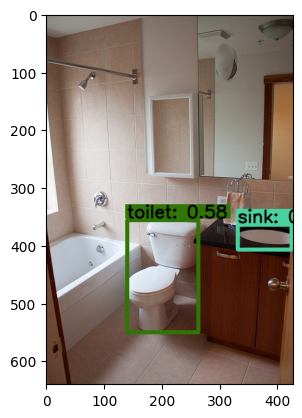

In [87]:
labels = get_coco_labels(LABEL_PATH)
colors = get_colors_from_labels(labels)

for bbox, score, class_id in zip(bboxes, scores, class_ids):
    y_min_scaled, x_min_scaled, y_max_scaled, x_max_scaled = bbox

    x_min = int(x_min_scaled / scaled_img.shape[2] * original_img.shape[1])
    y_min = int(y_min_scaled / scaled_img.shape[1] * original_img.shape[0])
    x_max = int(x_max_scaled / scaled_img.shape[2] * original_img.shape[1])
    y_max = int(y_max_scaled / scaled_img.shape[1] * original_img.shape[0])

    label = labels[int(class_id)]
    color = tuple([int(c) for c in colors[int(class_id)]])
    draw_bbox_with_label(original_img, x_min, y_min, x_max, y_max, score, label, color)

plt.imshow(original_img)